# Calculate a growth time distribution from a given length distribution
These calculations are used to generate some of the figures in [A. Fang, M. Haataja, “Modeling and Analysis of Electrodeposition in Porous Templates”, Journal of the Electrochemical Society, 164 (13) D875-D887 (2017)](https://altafangcom.files.wordpress.com/2016/12/fang_haataja_jes2017.pdf). 

In [14]:
# Python 3

%matplotlib inline

import numpy
from matplotlib import pyplot
import scipy.integrate

Define some functions for transforming from nanowire length distributions to growth time distributions.

In [3]:
def g(x, prefactor):
    """Here, prefactor = (t_eval - t_nucl)/t_c,peak."""
    return 1. - numpy.sqrt(1. - prefactor/x)

def dgdx(x, prefactor):
    return -prefactor/(2.*x**2*numpy.sqrt(1. - prefactor/x))

def ginv(y, prefactor):
    return prefactor/(1. - (y - 1.)**2)

def f_normal(y, mu, sigma):
    """Normal distribution"""
    return 1./numpy.sqrt(2.*sigma**2*numpy.pi)*numpy.exp(-(y - mu)**2/(2.*sigma**2))

def f_bimodal(y, mu1, sigma1, mu2, sigma2, p):
    """Bimodal distribution (here, a mixture of two Gaussians)"""
    return p*f_normal(y, mu1, sigma1) + (1 - p)*f_normal(y, mu2, sigma2)

def f_X(x, f_Y, prefactor, *args, **kwds):
    return f_Y(g(x, prefactor), *args)*numpy.abs(dgdx(x, prefactor))

def calc_FWHM(domain, f_vals):
    """Extract the full width half max of the larger peak.
    (this assumes the peaks won't interfere with each other)"""
    max_f = numpy.max(f_vals)
    whereabovehalf = numpy.where(f_vals >= max_f/2.)[0]
    fwhm = domain[whereabovehalf[-1]] - domain[whereabovehalf[0]]
    return fwhm

def calc_prefactor(ys, f_Y_vals):
    """Calculate prefactor, which is based on the peak of the nanowire length distribution."""
    maxlength = ys[numpy.argmax(f_Y_vals)]
    prefactor = 1. - (maxlength - 1.)**2
    return prefactor

## Analysis of a specific nanowire length distribution

Next, input the parameters for the input nanowire length distribution, and plot it. 

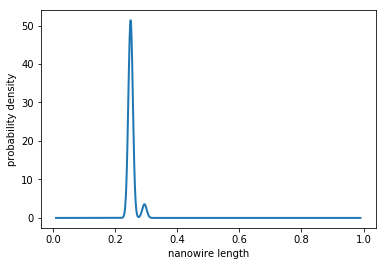

In [4]:
# Define mu1, sigma1, mu2, sigma2, p. 
# These values came from analysis of the experimental image. 
# You can change these depending on the distribution you want to analyze.
mu1 = 0.2500512
sigma1 = (5.273971e-05)**0.5
mu2 = 0.2946272 
sigma2 = (5.273971e-05)**0.5
p = 0.93516783

# Define the domain of normalized lengths (y values)
ys = numpy.linspace(0.01, 0.99, 10000)

# Plot the input distribution g(y)
f_Y_vals = f_bimodal(ys, mu1, sigma1, mu2, sigma2, p)
pyplot.plot(ys, f_Y_vals, linewidth=2)
pyplot.xlabel("nanowire length")
pyplot.ylabel("probability density")
pyplot.show()

(t_eval - t_nucl)/t_c,peak =  0.437539003224


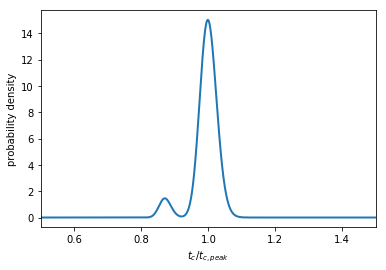

In [15]:
# Extract (t-t_nucl)/t_c,peak
prefactor = calc_prefactor(ys, f_Y_vals)
print("(t_eval - t_nucl)/t_c,peak = ", prefactor)

# Plot the backed-out distribution of t_{c,peak}/t_c
xs = ginv(ys, prefactor)[::-1] # put xs in increasing order
f_X_vals = f_X(xs, f_bimodal, prefactor, mu1, sigma1, mu2, sigma2, p)
pyplot.plot(xs, f_X_vals, linewidth=2)
pyplot.xlabel("$t_c/t_{c,peak}$")
pyplot.ylabel("probability density")
pyplot.xlim([0.5, 1.5])
pyplot.show()

In [7]:
# Save for gnuplot
numpy.savetxt("nanowire_length_distribution_twopeaks.txt", numpy.column_stack((ys, f_Y_vals)))
numpy.savetxt("growth_time_distribution.txt", numpy.column_stack((xs, f_X_vals)))

## More general case
Next, we consider how the spread in growth times varies with mean and spread of nanowire lengths for arbitrary Gaussian distributions of nanowire lengths.

In [8]:
def growth_time_spreads(mus, sigmas):
    """Calculate FWHM of growth time distributions for normal distributions 
    of nanowire lengths with each combination of the input mu and sigma values."""
    ys = numpy.linspace(0.01, 0.99, 10000)
    spreads = numpy.zeros((len(mus), len(sigmas)))
    
    for i, mu in enumerate(mus):
        for j, sigma in enumerate(sigmas):
            # Calculate the backed-out f(x)
            f_Y_vals = f_normal(ys, mu, sigma)
            prefactor = calc_prefactor(ys, f_Y_vals)
            xs = ginv(ys, prefactor)[::-1] # put xs in increasing order
            f_X_vals = f_X(xs, f_normal, prefactor, mu, sigma)

            # Extract the full width half max of the larger peak
            fwhm = calc_FWHM(xs, f_X_vals)
            spreads[i][j] = fwhm
    return spreads

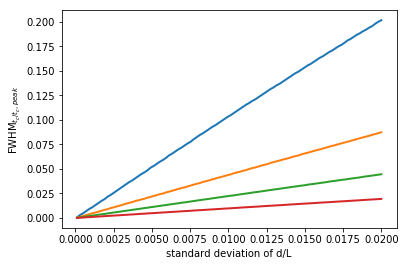

In [12]:
# Consider select mu values over a range of sigma values
mus_select = numpy.array([0.2, 0.4, 0.6, 0.8]) # mean of nanowire length peak
sigmas_all = numpy.linspace(1.e-4, 2.e-2, 100) # width of nanowire length peak

spreads_select_mu = growth_time_spreads(mus_select, sigmas_all)
for i, mu in enumerate(mus_select):
    # Save for gnuplot
    numpy.savetxt("t_c_vs_sigma_mu%.1f.txt" % mu, 
                  numpy.column_stack((sigmas_all, spreads_select_mu[i,:])))
    pyplot.plot(sigmas_all, spreads_select_mu[i,:], '-', linewidth=2)
pyplot.xlabel("standard deviation of d/L")
pyplot.ylabel("FWHM$_{t_c/t_c,peak}$")
pyplot.show()

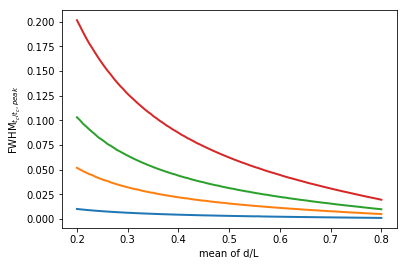

In [13]:
# Consider select sigma values over a range of mu values
sigmas_select = numpy.array([1.e-3, 5.e-3, 1.e-2, 2.e-2]) # width of nanowire length peak
mus_all = numpy.linspace(0.2, 0.8, 100) # mean of nanowire length peak

spreads_select_sigma = growth_time_spreads(mus_all, sigmas_select)
for i, sigma in enumerate(sigmas_select):
    # Save for gnuplot
    numpy.savetxt("t_c_vs_mu_sigma%f.txt" % sigma, 
                  numpy.column_stack((mus_all, spreads_select_sigma[:,i])))
    pyplot.plot(mus_all, spreads_select_sigma[:,i], '-', linewidth=2)
pyplot.xlabel("mean of d/L")
pyplot.ylabel("FWHM$_{t_c/t_c,peak}$")
pyplot.show()